In [1]:
!pip install -q torch_snippets
from torch_snippets import *
!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip -q face-detection.zip
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 101.0 MB/s eta

In [2]:
class SiameseNetworkDataset(Dataset):
  def __init__(self, folder, transform=None, should_invert=True):
    self.folder = folder
    self.items = Glob(f'{self.folder}/*/*')
    self.transform = transform

  def __getitem__(self, ix):
    itemA = self.items[ix]
    person = fname(parent(itemA))
    same_person = randint(2)
    if same_person:
      itemB = choose(Glob(f'{self.folder}/{person}/*', silent=True))
    else:
      while True:
        itemB = choose(self.items)
        if person != fname(parent(itemB)):
          break
    imgA = read(itemA)
    imgB = read(itemB)
    if self.transform:
      imgA = self.transform(imgA)
      imgB = self.transform(imgB)
    return imgA, imgB, np.array([1 - same_person])

  def __len__(self):
    return len(self.items)

In [3]:
from torchvision import transforms

trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01, 0.2), scale=(0.9, 1.1)),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds=SiameseNetworkDataset(folder="./data/faces/training/", transform=trn_tfms)
val_ds=SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)
trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64)

In [4]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [6]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

In [7]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [8]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [9]:
n_epochs = 200
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)
    if epoch==10: optimizer = optim.Adam(model.parameters(), lr=0.0005)

EPOCH: 20.000  trn_acc: 0.705  trn_loss: 0.587  val_acc: 0.800  val_loss: 0.332  (28.23s - 254.05s remaining)
EPOCH: 40.000  trn_acc: 0.774  trn_loss: 0.450  val_acc: 0.767  val_loss: 0.359  (49.46s - 197.82s remaining)
EPOCH: 60.000  trn_acc: 0.792  trn_loss: 0.470  val_acc: 0.933  val_loss: 0.431  (68.47s - 159.76s remaining)
EPOCH: 80.000  trn_acc: 0.829  trn_loss: 0.283  val_acc: 0.967  val_loss: 0.268  (86.89s - 130.34s remaining)
EPOCH: 100.000  trn_acc: 0.829  trn_loss: 0.321  val_acc: 0.900  val_loss: 0.104  (106.12s - 106.12s remaining)
EPOCH: 120.000  trn_acc: 0.876  trn_loss: 0.234  val_acc: 0.933  val_loss: 0.065  (124.64s - 83.09s remaining)
EPOCH: 140.000  trn_acc: 0.855  trn_loss: 0.233  val_acc: 0.867  val_loss: 0.176  (145.33s - 62.29s remaining)
EPOCH: 160.000  trn_acc: 0.883  trn_loss: 0.206  val_acc: 0.833  val_loss: 0.208  (163.73s - 40.93s remaining)
EPOCH: 180.000  trn_acc: 0.929  trn_loss: 0.191  val_acc: 0.900  val_loss: 0.130  (182.68s - 20.30s remaining)
EPOC

100%|██████████| 301/301 [00:00<00:00, 452.84it/s]


[10/16/23 03:51:29] INFO     metric val_loss was not fully recorded. Plotting final epochs using last recorded value                         ]8;id=773313;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py:236\torch_loader.py]8;;\:]8;id=589164;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py:236#plot_epochs:236\plot_epochs:236]8;;\

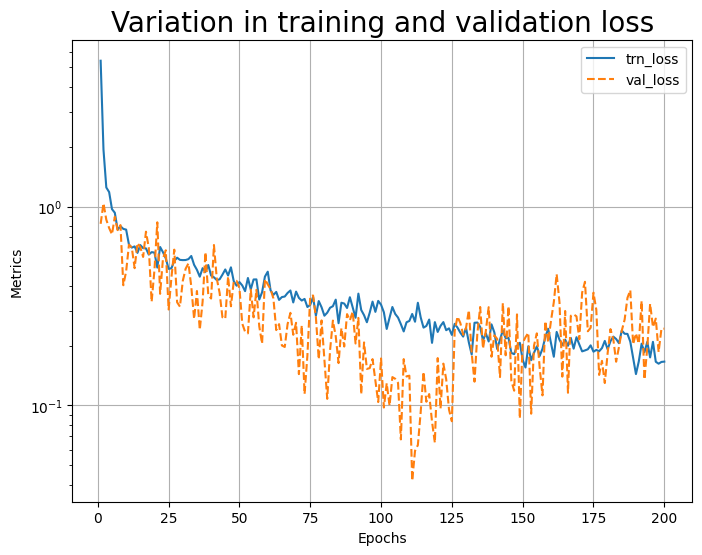

100%|██████████| 301/301 [00:00<00:00, 1272.86it/s]


[10/16/23 03:51:31] INFO     metric val_acc was not fully recorded. Plotting final epochs using last recorded value                          ]8;id=516643;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py:236\torch_loader.py]8;;\:]8;id=424510;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/torch_loader.py:236#plot_epochs:236\plot_epochs:236]8;;\

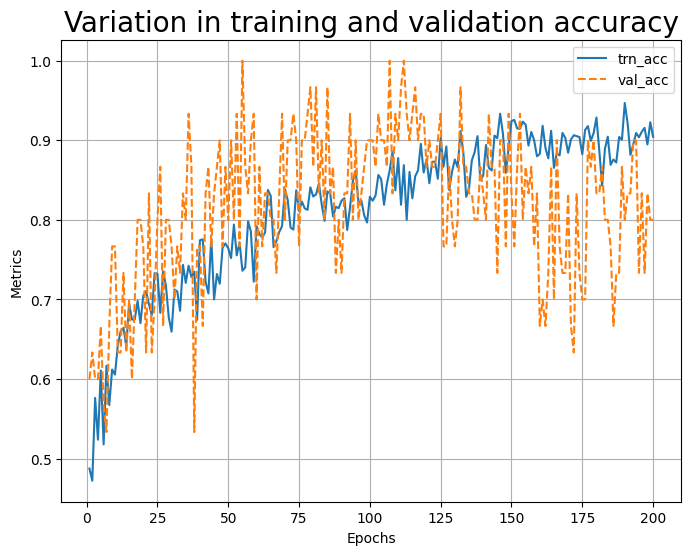

In [10]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


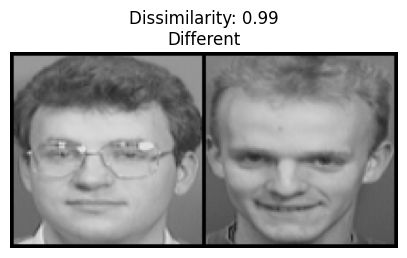

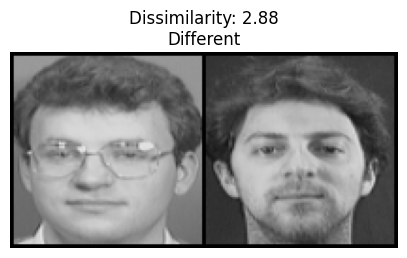

In [11]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()

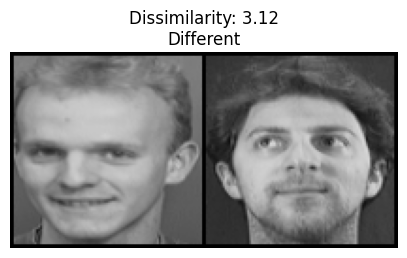

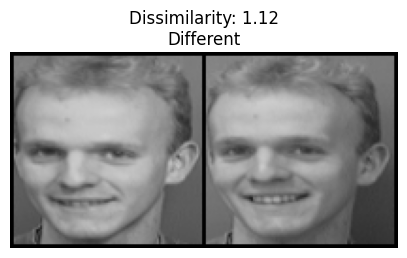

In [12]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()

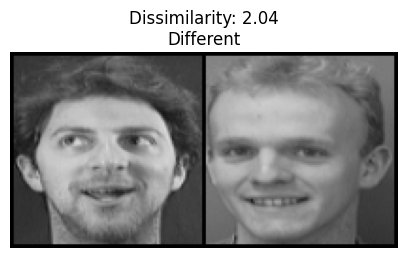

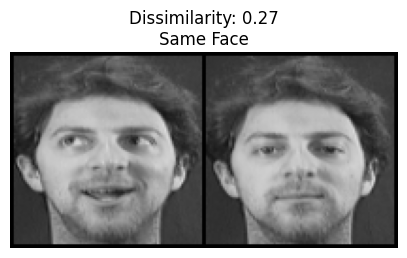

In [13]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()

---